## Sztuczne sieci neuronowe - laboratorium 5

### Sieci neuronowe - klasyfikacja

Na poprzednich zajęciach wytrenowaliśmy prostą sieć neuronową w zagadnieniu regresji.

Dzisiejsze laboratorium będzie dotyczyło wykorzystania (gęstej) sieci neuronowej do klasyfikacji. Będziemy pracowali z danymi obrazkowymi.

Poza biblioteką `torch` należy także doinstalować pakiet `torchvision`.

In [36]:
#!pip install torchvision

In [37]:
import torch
import torch.nn as nn
import torch.optim as optim

print(torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

2.6.0+cu126
Using device: cuda


In [38]:
from torchvision import datasets
from torchvision import transforms

### CIFAR-10
Zbiór CIFAR-10 składa się z 60 tysięcy kolorowych obrazków (RGB) rozmiaru 32x32 reprezentujących 10 klas obiektów:
- 0 - samoloty (airplane)
- 1 - samochody (automobile)
- 2 - ptaki (bird)
- 3 - koty (cat)
- 4 - jelenie (deer)
- 5 - psy (dog)
- 6 - żaby (frog)
- 7 - konie (horse)
- 8 - statki (ship)
- 9 - ciężarówki (truck)

Został opracowany przez naukowców z CIFAR - Canadian Institute For Advanced Research.

Biblioteka `torchvision` zawiera implementacje modeli sieci neuronowych wykorzystywanych do przetwarzania obrazu (wrócimy do nich w późniejszych laboratoriach), a także ma wbudowane przykładowe zbiory danych - CIFAR-10, CIFAR-100, MNIST, Fashion-MNIST i inne.

In [39]:
class_names = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck"
}

#### Ćwiczenie

W `torchvision.datasets` dostępna jest klasa `CIFAR10`, która pozwala wczytać (lub pobrać i wczytać) dane pochodzące z tego zbioru. Można to zrobić tworząc obiekt tej klasy, podając jako argumenty konstruktora kolejno:
- katalog z danymi (lub do którego dane mają zostać pobrane)
- parametr `train` typu True/False - do wczytania osobno zbioru uczącego i walidacyjnego
- parametr `download` - True/False czy w przypadku braku danych w podanym katalogu PyTorch ma je pobrać na dysk

Wczytaj zbiór uczący i walidacyjny odpowiednio do zmiennych `cifar10` i `cifar10_val`.
Wywołaj `type(cifar10).__mro__`, aby sprawdzić, jakiej klasy jest ten obiekt i po jakich klasach ona dziedziczy (MRO - Method Resolution Order).

In [40]:
cifar10 = datasets.CIFAR10(
    root="data",
    train=True,
    download=True
)
cifar10_val = datasets.CIFAR10(
    root="data",
    train=False,
    download=True
)


print(type(cifar10).__mro__)

(<class 'torchvision.datasets.cifar.CIFAR10'>, <class 'torchvision.datasets.vision.VisionDataset'>, <class 'torch.utils.data.dataset.Dataset'>, <class 'typing.Generic'>, <class 'object'>)


### Klasa Dataset

W PyTorchu do reprezentowania zbiorów danych typowo wykorzystuje się klasę `torch.utils.data.Dataset`. Obiekty tej klasy muszą posiadać implementacje co najmniej dwóch metod: **\_\_len\_\_** oraz **\_\_getitem\_\_**. Pierwsza z nich powinna zwracać liczbę obserwacji w zbiorze danych, a druga - element zbioru (cechy i etykietę - w przypadku uczenia z nadzorem) odpowiadający podanemu indeksowi.

Metodę \_\_len\_\_ w Pythonie wywołuje się jako **len(obiekt)**. Metodę \_\_getitem\_\_ - poprzez **obiekt[indeks]** - tak jak np. w przypadku listy.

#### Ćwiczenie
Sprawdź wywołania powyżej opisanych metod dla `cifar10` i `cifar10_val` (wybierz dowolny indeks - lub kilka różnych po kolei - z dozwolonego zakresu). Do zapoznania się ze zbiorem danych wykorzystaj funkcję `plt.imshow(img)` i sprawdź zgodność etykiety z obrazkiem z wykorzystaniem słownika `class_names`.

In [41]:
len(cifar10)

50000

In [42]:
len(cifar10_val)

10000

In [43]:
import matplotlib.pyplot as plt

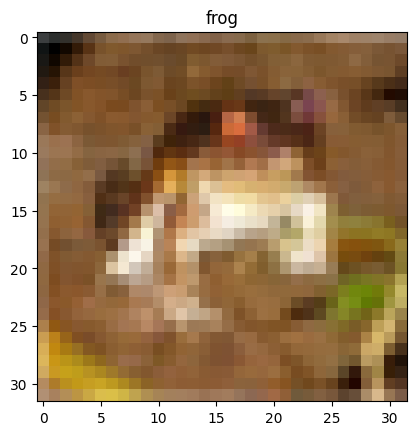

In [44]:
img, label = cifar10[0]
plt.imshow(img)
plt.title(class_names[label])
plt.show()

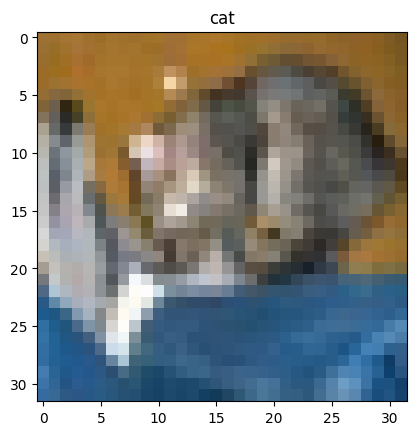

In [45]:
img, label = cifar10_val[0]
plt.imshow(img)
plt.title(class_names[label])
plt.show()

### Obrazek jako tensor

Wczytany z użyciem `torchvision` zbiór CIFAR10 zawiera obrazki w postaci obiektów klasy `PIL.Image`. Przed użyciem w treningu modelu należy je przekształcić do postaci tensorów. Różne transformacje obrazów są dostępne w `torchvision.transforms` - będziemy się nimi zajmować mocniej w późniejszym czasie (np. przy okazji zagadnienia "data augmentation"). Dziś wykorzystamy je do konwersji obrazków RGB do tensorów oraz do normalizacji danych.

In [46]:
from torchvision import transforms

In [47]:
dir(transforms)

['AugMix',
 'AutoAugment',
 'AutoAugmentPolicy',
 'CenterCrop',
 'ColorJitter',
 'Compose',
 'ConvertImageDtype',
 'ElasticTransform',
 'FiveCrop',
 'GaussianBlur',
 'Grayscale',
 'InterpolationMode',
 'Lambda',
 'LinearTransformation',
 'Normalize',
 'PILToTensor',
 'Pad',
 'RandAugment',
 'RandomAdjustSharpness',
 'RandomAffine',
 'RandomApply',
 'RandomAutocontrast',
 'RandomChoice',
 'RandomCrop',
 'RandomEqualize',
 'RandomErasing',
 'RandomGrayscale',
 'RandomHorizontalFlip',
 'RandomInvert',
 'RandomOrder',
 'RandomPerspective',
 'RandomPosterize',
 'RandomResizedCrop',
 'RandomRotation',
 'RandomSolarize',
 'RandomVerticalFlip',
 'Resize',
 'TenCrop',
 'ToPILImage',
 'ToTensor',
 'TrivialAugmentWide',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_functional_pil',
 '_functional_tensor',
 '_presets',
 'autoaugment',
 'functional',
 'transforms']

#### Ćwiczenie

Do konwersji wybranego obrazka z CIFAR10 z `PIL.Image` do `torch.Tensor` użyj transformacji `transforms.ToTensor()`. Należy najpierw przypisać `transforms.ToTensor()` do zmiennej, np. `to_tensor`, a następnie wywołać `to_tensor(img)` i wynik przypisać do zmiennej, np. `img_t`.

1. Sprawdź zawartość `img_t` oraz wartość `img_t.shape`. Zajrzyj też w "oryginalny" `img` - użyj `list(img.getdata())`.
2. Co się stało z wartościami w `img_t` w porównaniu z `img`? Jak zinterpretować kolejne wymiary tego tensora w `img_t.shape`?

- https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.ToTensor

In [48]:
to_tensor = transforms.ToTensor()
img_t = to_tensor(img)

In [49]:
print(img_t)
print(img_t.shape)

tensor([[[0.6196, 0.6235, 0.6471,  ..., 0.5373, 0.4941, 0.4549],
         [0.5961, 0.5922, 0.6235,  ..., 0.5333, 0.4902, 0.4667],
         [0.5922, 0.5922, 0.6196,  ..., 0.5451, 0.5098, 0.4706],
         ...,
         [0.2667, 0.1647, 0.1216,  ..., 0.1490, 0.0510, 0.1569],
         [0.2392, 0.1922, 0.1373,  ..., 0.1020, 0.1137, 0.0784],
         [0.2118, 0.2196, 0.1765,  ..., 0.0941, 0.1333, 0.0824]],

        [[0.4392, 0.4353, 0.4549,  ..., 0.3725, 0.3569, 0.3333],
         [0.4392, 0.4314, 0.4471,  ..., 0.3725, 0.3569, 0.3451],
         [0.4314, 0.4275, 0.4353,  ..., 0.3843, 0.3725, 0.3490],
         ...,
         [0.4863, 0.3922, 0.3451,  ..., 0.3804, 0.2510, 0.3333],
         [0.4549, 0.4000, 0.3333,  ..., 0.3216, 0.3216, 0.2510],
         [0.4196, 0.4118, 0.3490,  ..., 0.3020, 0.3294, 0.2627]],

        [[0.1922, 0.1843, 0.2000,  ..., 0.1412, 0.1412, 0.1294],
         [0.2000, 0.1569, 0.1765,  ..., 0.1216, 0.1255, 0.1333],
         [0.1843, 0.1294, 0.1412,  ..., 0.1333, 0.1333, 0.

In [50]:
print(list(img.getdata()))

[(158, 112, 49), (159, 111, 47), (165, 116, 51), (166, 118, 53), (160, 112, 46), (156, 109, 41), (162, 115, 47), (159, 113, 45), (158, 111, 44), (159, 113, 41), (161, 116, 41), (160, 111, 52), (161, 111, 49), (166, 117, 41), (169, 117, 45), (170, 119, 44), (167, 117, 40), (162, 113, 38), (160, 111, 39), (160, 112, 43), (156, 109, 44), (149, 107, 45), (150, 107, 45), (148, 106, 43), (149, 107, 44), (143, 101, 39), (140, 98, 43), (141, 97, 41), (143, 97, 38), (137, 95, 36), (126, 91, 36), (116, 85, 33), (152, 112, 51), (151, 110, 40), (159, 114, 45), (166, 116, 56), (162, 112, 49), (160, 113, 43), (164, 117, 47), (162, 114, 45), (163, 116, 46), (156, 110, 38), (155, 111, 41), (159, 110, 54), (163, 113, 52), (170, 119, 41), (171, 117, 40), (171, 115, 33), (169, 115, 30), (160, 111, 33), (154, 112, 41), (151, 115, 50), (145, 110, 53), (139, 104, 55), (140, 102, 52), (141, 100, 48), (149, 105, 50), (147, 102, 46), (145, 102, 45), (142, 97, 38), (143, 98, 34), (136, 95, 31), (125, 91, 32), (

1. Dane zostały znormalizowane do przedziału [0, 1].
2. Pierwszy wymiar tensora to kanał (RGB), drugi wymiar to wysokość, trzeci wymiar to szerokość. W przypadku obrazków RGB mamy 3 kanały (R, G, B), a wymiary obrazka to 32x32 piksele.

#### Ćwiczenie
Transformację `ToTensor()` można podać jako argument `transform` przy tworzeniu zbioru danych jako `Dataset`. Tak utworzony zbiór od razu będzie zawierał PyTorchowe tensory, a nie obrazki `PIL.Image`.

Stwórz `tensor_cifar10` i `tensor_cifar10_val` zawierające tensory.

In [51]:
tensor_cifar10 = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=to_tensor
)
tensor_cifar10_val = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=to_tensor
)

#### Ćwiczenie
Uruchom poniższą komórkę, aby zwizualizować tensor `img_t` z użyciem `plt.imshow()`. Funkcja ta oczekuje innej kolejności współrzędnych (H x W x C) niż zawarta w tensorze (C x H x W) - stąd konieczność użycia metody `permute()`.

H - wysokość, W - szerokość, C - kanał (RGB)

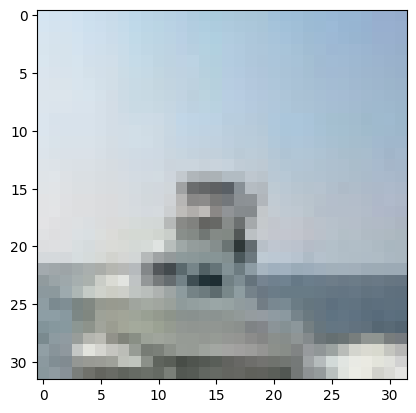

ship


In [52]:
index = 100

img_t, label = tensor_cifar10[index]
plt.imshow(img_t.permute(1, 2, 0))
plt.show()

print(class_names[label])

### Normalizacja danych

Przed użyciem w sieci neuronowej, należy odpowiednio znormalizować dane - normalizacja ułatwia (przyspiesza i stabilizuje) trening modelu.

Typowym sposobem normalizacji danych obrazkowych jest standaryzacja każdego z dostępnych kanałów - odjęcie policzonej dla niego średniej ze zbioru uczącego i podzielenie przez jego odchylenie standardowe.

#### Ćwiczenie
Uruchom kolejne komórki. Spróbuj wyjaśnić, co się w nich dzieje.

- https://pytorch.org/docs/stable/generated/torch.stack.html (dla przypomnienia)
- https://pytorch.org/docs/stable/tensors.html#torch.Tensor.view

In [53]:
imgs = torch.stack([img_t for img_t, _ in tensor_cifar10], dim=3) # zmienna imgs przechowuje wszystkie obrazki w tensorze, w nowych wymiarach, które pasują do funkcji plt.imshow

In [54]:
imgs.shape # wyświetlenie kształtu tensora

torch.Size([3, 32, 32, 50000])

In [55]:
per_channel_means = imgs.view(3, -1).mean(dim=1) # średnia wartość każdego kanału
per_channel_std = imgs.view(3, -1).std(dim=1) # odchylenie standardowe każdego kanału

#### Ćwiczenie

Do normalizacji danych w `torchvision.transforms` słuzy `transforms.Normalize`, której należy podać średnie i odchylenia standardowe dla każdego z kanałów. `transforms.Compose` pozwala natomiast łączyć transformacje w sekwencje - są one aplikowane do danych ładowanych do `Dataset` po kolei.

`transforms.Compose` przyjmuje jako argument listę kolejnych transformacji.

Załaduj zbiór danych do zmiennej `transformed_cifar10`, podając jako argument `transform` złożenie transformacji `ToTensor` i `Normalize`

Sprawdź zawartość dowolnego tensora z `transformed_cifar10`.


- https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.Normalize
- https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.Compose


In [56]:
transformed_cifar10 = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=transforms.Compose([
        to_tensor,
        transforms.Normalize(per_channel_means, per_channel_std)
    ]))
transformed_cifar10_val = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=transforms.Compose([
        to_tensor,
        transforms.Normalize(per_channel_means, per_channel_std)
    ]))
print(transformed_cifar10[0][0])

tensor([[[-1.0526e+00, -1.3066e+00, -1.1955e+00,  ...,  5.1899e-01,
           4.2375e-01,  3.6025e-01],
         [-1.7352e+00, -1.9892e+00, -1.7035e+00,  ..., -3.6622e-02,
          -1.0012e-01, -5.2496e-02],
         [-1.5923e+00, -1.7352e+00, -1.2114e+00,  ..., -1.1600e-01,
          -8.4246e-02, -2.5887e-01],
         ...,
         [ 1.3127e+00,  1.2016e+00,  1.1540e+00,  ...,  5.5074e-01,
          -1.1002e+00, -1.1479e+00],
         [ 8.6824e-01,  7.5711e-01,  9.6349e-01,  ...,  9.3174e-01,
          -4.4936e-01, -6.7161e-01],
         [ 8.2061e-01,  6.7774e-01,  8.5236e-01,  ...,  1.4397e+00,
           4.0787e-01, -3.6622e-02]],

        [[-9.8167e-01, -1.2394e+00, -1.2072e+00,  ...,  1.4575e-01,
           3.3011e-02,  1.6905e-02],
         [-1.6581e+00, -1.9802e+00, -1.8514e+00,  ..., -5.6291e-01,
          -6.4344e-01, -5.7902e-01],
         [-1.5937e+00, -1.8675e+00, -1.5454e+00,  ..., -6.2733e-01,
          -6.2733e-01, -8.0450e-01],
         ...,
         [ 7.5778e-01,  4

### Klasyfikacja binarna - ptak czy samolot?

Po przygotowaniu zbioru danych przejdziemy teraz do zadania klasyfikacji binarnej.

Wyobraź sobie, że jesteś leniwym miłośnikiem ptaków, i zamiast wyczekiwać długimi godzinami w lesie, chciałbyś/chciałabyś zautomatyzować proces robienia zdjęć ptakom. Niestety Twój system kamer jest dość wrażliwy i robi zdjęcia często także przelatującym samolotom. Postanawiasz wytrenować sieć neuronową, która wykryje zdjęcia samolotów i usunie je z Twojego systemu.

#### Ćwiczenie

Do opisanego problemu klasyfikacji binarnej możemy wykorzystać podzbiór `CIFAR-10`, wybierając odpowiednio dwie z 10 dostępnych klas. Przypisz im (z wykorzystaniem słownika `label_map`) nowe etykiety - 0 i 1.

Uwaga:
Stworzone w ten sposób `cifar2` i `cifar2_val` nie będą obiektami klasy `Dataset`, ale na potrzeby dzisiejszych zajęć w zupełności wystarczy nam lista - posiada ona implementacje `__len__` i `__getitem__`.  Wykorzystaj "list comprehension" do przefiltrowania `transformed_cifar10` i `transformed_cifar10_val`.

In [57]:
label_map = {
    0: 0, # airplane
    2: 1, # bird
}
new_class_names  = [class_names[i] for i in label_map]

cifar2 = [
    (img, label_map[label]) for img, label in transformed_cifar10 if label in label_map
]
cifar2_val = [
    (img, label_map[label]) for img, label in transformed_cifar10_val if label in label_map
]

### Gęsta sieć neuronowa

Zbudujemy teraz model sieci neuronowej, wykorzystując poznane poprzednio moduły z `torch.nn`.

Na początek niech sieć składa się kolejno z:
- warstwy liniowej
- funkcji aktywacji
- drugiej warstwy liniowej

Do zbudowania sieci użyj `nn.Sequential` oraz odpowiednich klas reprezentujących warstwy liniowe i wybraną funkcję aktywacji.

#### Ćwiczenie

Zbuduj sieć neuronową, zgodnie z powyższą (i poniższą) instrukcją. Przypisz model do zmiennej `model`.

1. Ile wejść powinna mieć taka sieć? Hint: wymiary / rozmiary tensora.
2. Ile wyjść powinna mieć taka sieć? Czy jedno wystarczy?
3. Niech liczba wyjść z pierwszej i wejść do drugiej warstwy liniowej wynosi 512 (arbitralna wartość).

In [58]:
n_in = 3072
n_hidden = 512
n_out = 2

model = nn.Sequential(
    nn.Linear(n_in, n_hidden),
    nn.Tanh(),
    nn.Linear(n_hidden, n_out)
)

### Wyjście z klasyfikatora - softmax

Wyjścia z powyżej zdefiniowanego modelu to tzw. logity - "surowe" wartości liczbowe - tyle wartości, ile wyjść. Im wyższa wartość danego logitu, tym model "bardziej przewiduje" klasę przypisaną do danego wyjścia.

Typowo w zagadnieniu klasyfikacji logity normalizuje się z użyciem funkcji **softmax** (przy jednym wyjściu "wystarczy" sigmoid). Wartości otrzymane w wyniku normalizacji można interpretować jako prawdopodobieństwa / pewności (ang. confidence scores) modelu co do predykcji klasy obiektu.

#### Ćwiczenie

Sprawdź działanie funkcji softmax zdefiniowanej poniżej oraz zaimplementowanej jako `nn.Softmax` na przykładowym tensorze.

In [59]:
def softmax(x):
    return torch.exp(x) / torch.exp(x).sum()

In [60]:
x = torch.tensor([1.0, 2.0, 3.0])
softmax(x)

tensor([0.0900, 0.2447, 0.6652])

In [61]:
softmax = nn.Softmax(dim=1)
x = torch.tensor([[1.0, 2.0, 3.0], [1.0, 2.0, 3.0]])
softmax(x)

tensor([[0.0900, 0.2447, 0.6652],
        [0.0900, 0.2447, 0.6652]])

#### Ćwiczenie
Rozbuduj poprzednio zbudowany model o `nn.Softmax` podając `dim=1` (dlaczego akurat 1? czym jest dim=0?)

- https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html

In [62]:
model = nn.Sequential(
    nn.Linear(n_in, n_hidden),
    nn.Tanh(),
    nn.Linear(n_hidden, n_out),
    nn.Softmax(dim=1) #dim określa, wzdłuż którego wymiaru ma być normalizowane wyjście 0 to wiersze, 1 to kolumny
)

#### Ćwiczenie
Przepuść przez model wybrany przykład ze zbioru `cifar2`. Czy model dobrze rozpoznał klasę? Jeśli tak - czy mamy gotowy model?

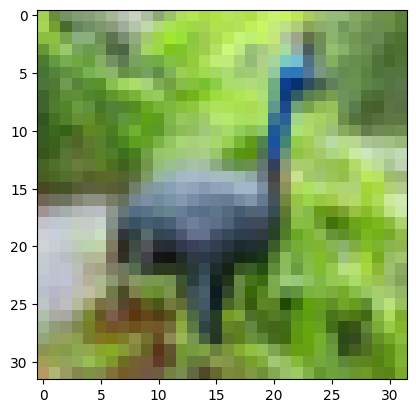

tensor([[0.4904, 0.5096]], grad_fn=<SoftmaxBackward0>)
bird


In [63]:
def denormalize(img_t, mean, std):
    img_t = img_t * std[:, None, None] + mean[:, None, None]
    return img_t

# wizualizacja obrazka
index = 0

img, _ = cifar2[index]

# denormalizacja
img = denormalize(img, per_channel_means, per_channel_std)
# zmiana wymiarów
img = img.view(3, 32, 32)
# zmiana kolejności wymiarów
plt.imshow(img.permute(1, 2, 0))
plt.show()

# "wypłaszczenie" obrazka + dodatkowy wymiar "1" (unsqueeze - patrz poprzednie zajęcia)
img_batch = img.view(-1).unsqueeze(0)

# przepuszczenie przez model
out = model(img_batch)
# prawdopodobieństwa klas
print(out)
# klasa predykcji
print(new_class_names[torch.argmax(out, dim=1).item()])

Pomimo, iż model poprawnie rozpoznał klasę, to nie jest gotowy, gdyż nadal nie została wyszkolony. W tej chwili model "losowo" przypisuje prawdopodobieństwa klasom - nie nauczył się jeszcze niczego.

### Funkcja straty w klasyfikacji

W przypadku zadania regresji jako funkcji straty używaliśmy błędu średniokwadratowego (MSE, `nn.MSELoss`).

W klasyfikacji zależy nam na tym, aby model nauczył się przypisywać wysokie prawdopodobieństwa prawidłowym klasom.

Funkcja straty typowo stosowana w klasyfikacji nazywa się **entropią krzyżową** (ang. cross-entropy loss, CE) lub **negative log-likelihood** (NLL) - używana nazwa zależy od kontekstu (matematycznego), ale oba pojęcia dotyczą tego samego "wzoru".

W `torch.nn` jest kilka alternatywnych implementacji realizujących tę funkcję straty, np.:
- `nn.NLLLoss` - przyjmuje na wejście zlogarytmowane prawdopodobieństwa klas - wymaga `nn.LogSoftmax` zamiast `nn.Softmax`
- `nn.CrossEntropyLoss` - przyjmuje na wejście logity - model bez softmaxu

czyli: `nn.CrossEntropyLoss` = `nn.LogSoftmax` + `nn.NLLLoss`

różnica: w przypadku `nn.CrossEntropyLoss` wyjścia nie będą znormalizowane - ale często wystarczą nam logity (jako predykcję modelu bierzemy klasę, dla której wartość logitu jest największa).

#### Ćwiczenie

Dla modelu z poprzedniego ćwiczenia oblicz wartość funkcji straty dla wybranego przykładu z `cifar2`. Uruchom komórkę kilka razy - co się dzieje i dlaczego?

In [64]:
model = nn.Sequential(
    nn.Linear(n_in, n_hidden),
    nn.Tanh(),
    nn.Linear(n_hidden, n_out),
    nn.LogSoftmax(dim=1)
)

loss = nn.NLLLoss()

index = 0
img, label = cifar2[index]
out = model(img.view(-1).unsqueeze(0))
loss(out, torch.tensor([label]))

tensor(0.8721, grad_fn=<NllLossBackward0>)

Średnia wartość funkcji straty maleje z każdym uruchomieniem komórki, ponieważ model "uczy się" i przypisuje coraz wyższe prawdopodobieństwa klasie 0 (samolot) i coraz niższe klasie 1 (ptak). Wartość funkcji straty jest tym mniejsza, im bardziej model jest pewny swojej predykcji.

### Stochastic Gradient Descent (SGD)

W poprzednich ćwiczeniach zbiór danych był mały (łącznie 11 obserwacji, w tym 9 w zbiorze uczącym) i w każdej iteracji treningu przepuszczaliśmy przez model cały dostępny zbiór.

W zbiorze `CIFAR` mamy łącznie po 6 tysięcy obrazków dla każdej z klas (5000 w zbiorze uczącym, 1000 w walidacyjnym). Nie będziemy w każdej iteracji treningu przepuszczać przez model całego zbioru danych (nie chodzi tylko o ograniczoną pamięć - model mógłby mieć wtedy problem z nauczeniem się).

Będziemy podawać dane w tzw. "batchach" (liczba przykładów podawanych jednocześnie, czyli batch size, jest hiperparametrem modelu).

Taki wariant algorytmu najszybszego spadku nazywa się:
- SGD - Stochastic Gradient Descent - gdy podajemy jeden przykład w każdej iteracji
- BGD - (Mini-)Batch Gradient Descent - gdy podajemy N przykładów (np. kilka / kilkanaście / kilkadziesiąt) w każdej iteracji

Uwaga:
W praktyce (i w literaturze) nazwa "SGD" używana jest tez w kontekście BGD.

#### Ćwiczenie

Poniższa komórka realizuje algorytm SGD - w każdej iteracji treningu puszczamy przez model jeden obrazek (druga pętla for).

Uruchom poniższą komórkę i obserwuj funkcję straty po każdej epoce treningu.

In [65]:
model = nn.Sequential(
    nn.Linear(3072, 512),
    nn.Tanh(),
    nn.Linear(512, 2),
    nn.LogSoftmax(dim=1)
)
model = model.to(device)

learning_rate = 1e-2
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.NLLLoss()
n_epochs = 5

for epoch in range(n_epochs):
    for img, label in cifar2:
        img, label = img.to(device), torch.tensor([label]).to(device)
        out = model(img.view(-1).unsqueeze(0))
        loss = loss_fn(out, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 3.946596
Epoch: 1, Loss: 7.285779
Epoch: 2, Loss: 10.745263
Epoch: 3, Loss: 7.350355
Epoch: 4, Loss: 7.462465


### (Mini-)Batch Gradient Descent

Jak już było wspomniane, zwykle w kolejnych iteracjach treningu podajemy modelowi "trochę" danych - tzw. batch.

Do ładowania kolejnych batchy danych w czasie treningu lub walidacji służy w PyTorchu klasa `DataLoader` z `torch.utils.data`.

Konstruktor tej klasy przyjmuje jako pierwszy argument `Dataset`. Inne interesujące argumenty to `batch_size` oraz `shuffle`.

- https://pytorch.org/docs/stable/data.html

Uwaga:  
Zwykle w każdej epoce treningu "przetasowuje się" zbiór danych. W walidacji kolejność batchy nie ma znaczenia.

#### Ćwiczenie

Stwórz `train_loader` dla zbioru uczącego i `val_loader` dla walidacyjnego, podając `batch_size` równy 64 i pamiętając o przetasowaniu danych (dla zbioru uczącego).

In [66]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

#### Ćwiczenie
Zmodyfikuj poprzednią pętlę treningową, aby zrealizować algortym batch gradient descent z wykorzystaniem stworzonego dataloadera.

In [67]:
for epoch in range(100):
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        out = model(imgs.view(imgs.size(0), -1))
        loss = loss_fn(out, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 0.253826
Epoch: 1, Loss: 0.510870
Epoch: 2, Loss: 0.455318
Epoch: 3, Loss: 0.961084
Epoch: 4, Loss: 0.628001
Epoch: 5, Loss: 0.291561
Epoch: 6, Loss: 0.340911
Epoch: 7, Loss: 0.425909
Epoch: 8, Loss: 0.310401
Epoch: 9, Loss: 0.064040
Epoch: 10, Loss: 0.140921
Epoch: 11, Loss: 0.281540
Epoch: 12, Loss: 0.438152
Epoch: 13, Loss: 0.205079
Epoch: 14, Loss: 0.169241
Epoch: 15, Loss: 0.155117
Epoch: 16, Loss: 0.259439
Epoch: 17, Loss: 0.290401
Epoch: 18, Loss: 0.232030
Epoch: 19, Loss: 0.051596
Epoch: 20, Loss: 0.166873
Epoch: 21, Loss: 0.320082
Epoch: 22, Loss: 0.259555
Epoch: 23, Loss: 0.086012
Epoch: 24, Loss: 0.331287
Epoch: 25, Loss: 0.201062
Epoch: 26, Loss: 0.303270
Epoch: 27, Loss: 0.259796
Epoch: 28, Loss: 0.256035
Epoch: 29, Loss: 0.251988
Epoch: 30, Loss: 0.223635
Epoch: 31, Loss: 0.070547
Epoch: 32, Loss: 0.133724
Epoch: 33, Loss: 0.116117
Epoch: 34, Loss: 0.338093
Epoch: 35, Loss: 0.173283
Epoch: 36, Loss: 0.213130
Epoch: 37, Loss: 0.299348
Epoch: 38, Loss: 0.197

### Walidacja modelu

Na koniec sprawdźmy, jaką dokładność predykcji uzyskamy na zbiorze walidacjnym dla naszej sieci gęstej.

#### Ćwiczenie

1. Uruchom poniższą komórkę, aby sprawdzić dokładność na zbiorze waldiacyjnym.
2. Sprawdź, jaki wynik uzyskasz, podmieniając `val_loader` na `train_loader` w pętli for.
3. Skomentuj uzyskane wyniki.

In [68]:
correct = 0
total = 0


with torch.no_grad():
    for imgs, labels in val_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        batch_size = imgs.shape[0]
        outputs = model(imgs.view(batch_size, -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())

print("Accuracy: %f" % (correct / total))

Accuracy: 0.764000


### Podsumowanie

- poznaliśmy możliwości PyTorcha w zakresie ładowania danych (`Dataset`, `DataLoader`) oraz obróbki danych obrazkowych (`torchvision.transforms`)
- poruszyliśmy takie zagadnienia jak funkcja straty w klasyfikacji (entropia krzyżowa, NLL) czy softmax
- wytrenowaliśmy binarny klasyfikator na podzbiorze zbioru `CIFAR-10` (`torchvision.datasets`) z użyciem algorytmu SGD

Sieci gęste nie sprawdzają się jednak w praktyce w przetwarzaniu obrazów - wkrótce poznamy tzw. sieci splotowe (ang. convolutional neural networks, CNN), które zrewolucjonizowały dziedzinę głębokiego uczenia maszynowego w 2012 roku.

### Wnioski
W ramach dodatkowego wyzwania, spróbowałem zrealizować ćwiczenie na własnej maszynie. Znacznie spowolniło to możliwości trenowania modelu, gdyż nie posiadam aż tak potężnego GPU.